In [1]:
# Standard library imports
import os
import argparse
import sys
import time
import json

# External library imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import h5py
import matplotlib.pyplot as plt
import copy
import joblib
from torch.nn import init

from sklearn.metrics import mean_squared_error
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import datetime
from torchinfo import summary

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 ; # pdf.fonttype : 42 # Output Type 3 (Type3) or Type 42 (TrueType)

In [2]:
def load_and_plot_h5(results_filepath, index, color_style='viridis', plot_name=None):
    # Load the HDF5 file
    with h5py.File(results_filepath, 'r') as h5file:
        group = h5file[index]

        # Extract data
        input_data = group['input'][:]
        output_data = group['output'][:]
        target_data = group['target'][:]
        loss = group.attrs['loss']

        # Plot the data
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(input_data, cmap=color_style, aspect='auto')
        axes[0].set_title('Input')
        axes[0].axis('off')

        axes[1].imshow(output_data, cmap=color_style, aspect='auto')
        axes[1].set_title('Output')
        axes[1].axis('off')

        axes[2].imshow(target_data, cmap=color_style, aspect='auto')
        axes[2].set_title(f'Target\nLoss: {loss:.4f}')
        axes[2].axis('off')

        if plot_name is not None:
            plt.savefig(plot_name)
        plt.show()



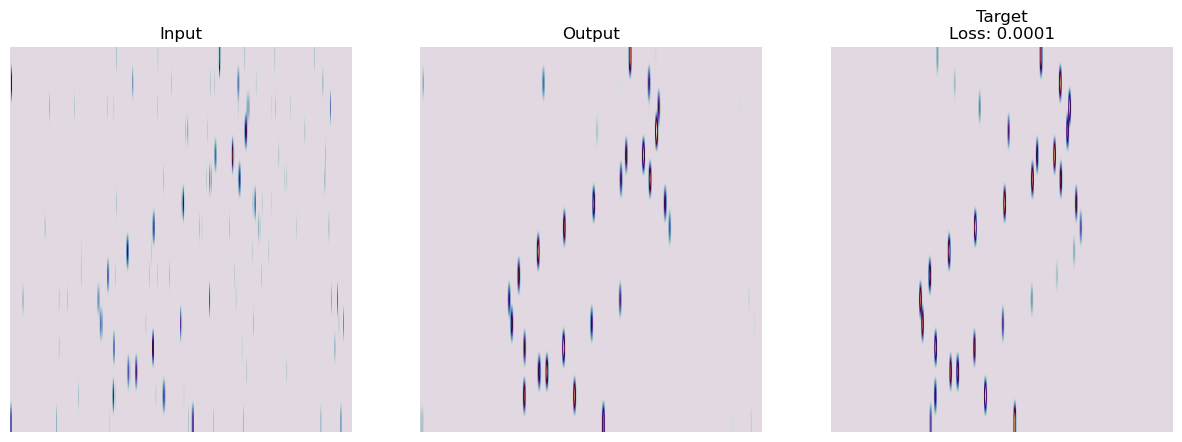

In [3]:
data_load = "/sdf/data/lcls/ds/prj/prjs2e21/results/COOKIE_ML_Output/denoising/run_07282024_multiPulse/outputs_fromEvenDist/testAutoencoder_eval_results.h5"
# data_load = "/sdf/scratch/lcls/ds/prj/prjs2e21/scratch/fast_data_access/even-dist_Pulses_03302024/Processed_07262024_0to1/test/"
index = "0_30"  # Replace with the index you want to plot
cmap = "twilight"
# cmap "plasma"
load_and_plot_h5(data_load, index, color_style=cmap, plot_name="/sdf/home/j/jhirschm/Publications/MRCO_XrayReconstruction_Paper_Results/denoised____.pdf")


In [4]:
with h5py.File(data_load, 'r') as h5file:
    keys=list(h5file.keys())
    print(keys[0])
    print(h5file[keys[0]]['input'][:])

0_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import torch.nn.init as init
import os
import joblib






import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib

# matplotlib.use('pgf')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from torch.optim.lr_scheduler import StepLR

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("MPS is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS is not available. Using CPU.")



def load_data(even_dir):
        # Your existing code for loading images
    images = []
    npulses = []

    for file_path in even_dir:
        print(file_path)
        with h5py.File(file_path, 'r') as h5f:
            for image_key in h5f.keys():
                npulse = h5f[image_key].attrs["npulses"]
                images.append(h5f[image_key]["Ximg"][:])
                npulses.append(npulse)

             

    # Convert the list of scaled images to a single NumPy array
    images_normalized = np.array(images)

    
    return images_normalized, npulses



MPS is not available. Using CPU.


In [6]:
new_file_path = ["/sdf/scratch/lcls/ds/prj/prjs2e21/scratch/fast_data_access/even-dist_Pulses_03302024/Processed_07262024_0to1/test/even-dist_Files.003_processed.h5"]
file_paths = new_file_path
images,npulses= load_data(file_paths)


/sdf/scratch/lcls/ds/prj/prjs2e21/scratch/fast_data_access/even-dist_Pulses_03302024/Processed_07262024_0to1/test/even-dist_Files.003_processed.h5


In [7]:
for index, npulse in enumerate(npulses[0:300]):
    if npulse == 1:
        print(f"Index: {index}, npulse: {npulse}")

Index: 14, npulse: 1
Index: 26, npulse: 1
Index: 29, npulse: 1
Index: 30, npulse: 1
Index: 34, npulse: 1
Index: 37, npulse: 1
Index: 43, npulse: 1
Index: 45, npulse: 1
Index: 47, npulse: 1
Index: 49, npulse: 1
Index: 53, npulse: 1
Index: 55, npulse: 1
Index: 58, npulse: 1
Index: 60, npulse: 1
Index: 62, npulse: 1
Index: 66, npulse: 1
Index: 69, npulse: 1
Index: 70, npulse: 1
Index: 73, npulse: 1
Index: 80, npulse: 1
Index: 83, npulse: 1
Index: 85, npulse: 1
Index: 86, npulse: 1
Index: 88, npulse: 1
Index: 94, npulse: 1
Index: 100, npulse: 1
Index: 102, npulse: 1
Index: 104, npulse: 1
Index: 107, npulse: 1
Index: 109, npulse: 1
Index: 115, npulse: 1
Index: 120, npulse: 1
Index: 124, npulse: 1
Index: 129, npulse: 1
Index: 130, npulse: 1
Index: 133, npulse: 1
Index: 136, npulse: 1
Index: 138, npulse: 1
Index: 143, npulse: 1
Index: 152, npulse: 1
Index: 172, npulse: 1
Index: 173, npulse: 1
Index: 178, npulse: 1
Index: 180, npulse: 1
Index: 204, npulse: 1
Index: 206, npulse: 1
Index: 209, n

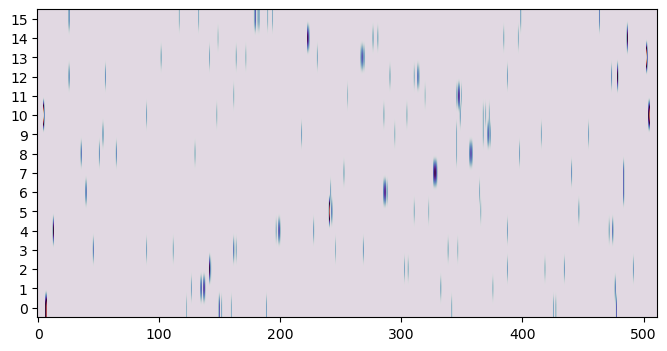

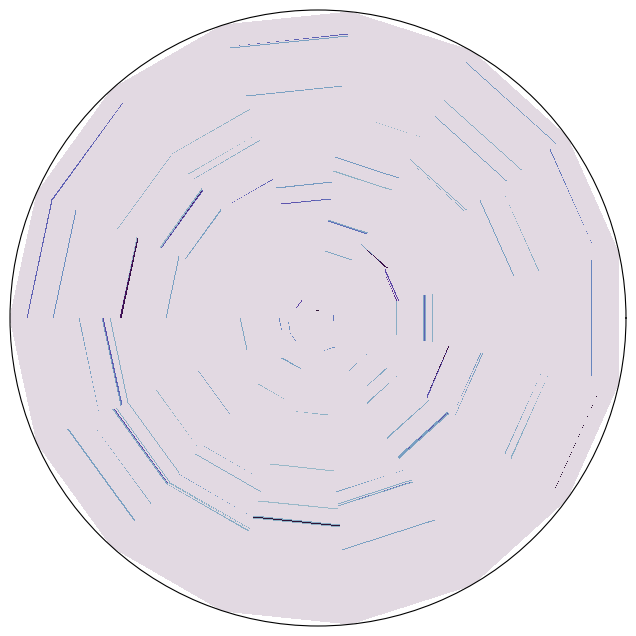

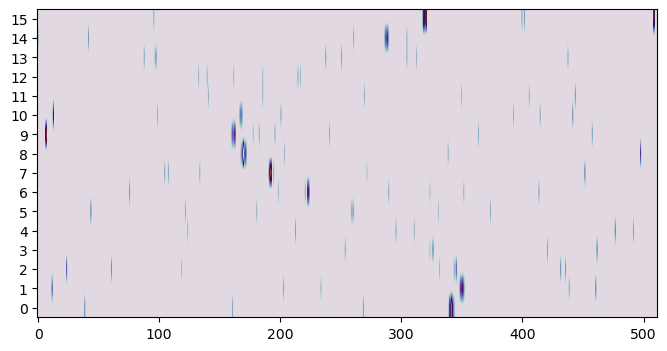

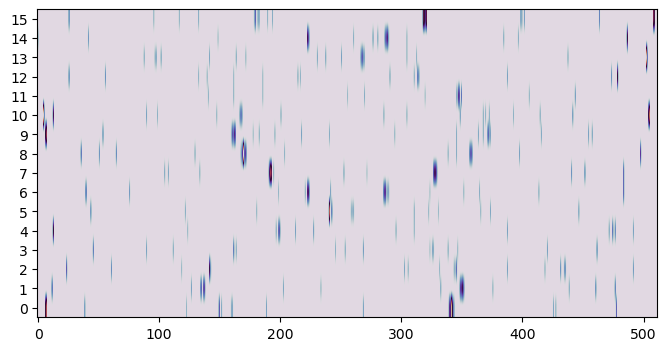

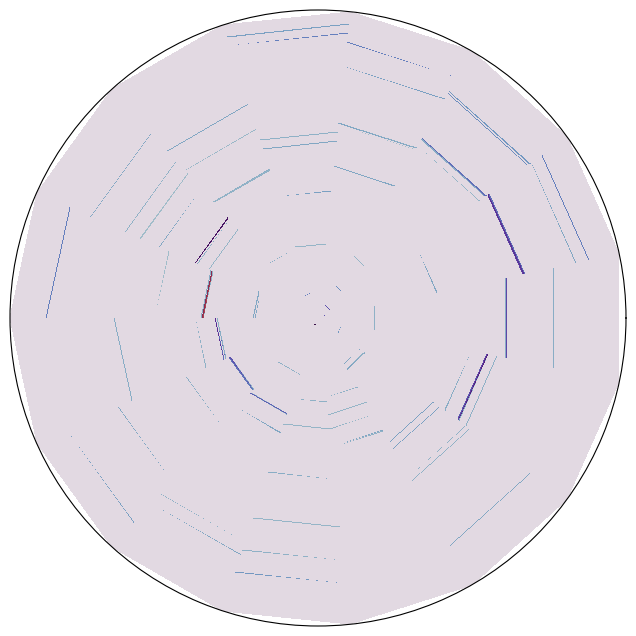

In [11]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from scipy.interpolate import CubicSpline

cmap = "twilight"

idx = 130#106#269
temp_image_1 = images[idx]

# Plot the sequence with custom color scheme and grid lines
plt.figure(figsize=(8, 4))
# Invert the y-axis to start from 0 at the bottom row
plt.imshow(temp_image_1, aspect='auto', cmap=cmap, origin='lower')
num_rows = temp_image_1.shape[0]
plt.yticks(np.arange(num_rows))
plt.savefig(f"/sdf/home/j/jhirschm/Publications/MRCO_XrayReconstruction_Paper_Results/sinogram_figure1_1.pdf", format='pdf')

# Create polar plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
# Set angles (assume each row corresponds to an angle)
angles = np.linspace(0, 2 * np.pi, 16, endpoint=True)
cax = ax.pcolormesh(angles, np.arange(512), temp_image_1.T, cmap=cmap,  rasterized=True,shading='nearest')
ax.grid(visible=False)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.savefig(f"/sdf/home/j/jhirschm/Publications/MRCO_XrayReconstruction_Paper_Results/polar_figure1_1.pdf", format='pdf')

plt.show()

idx = 138#277
temp_image_2 = images[idx]

plt.figure(figsize=(8, 4))
plt.imshow(temp_image_2, aspect='auto', cmap=cmap, origin='lower')
num_rows = temp_image_2.shape[0]
plt.yticks(np.arange(num_rows))
plt.savefig(f"/sdf/home/j/jhirschm/Publications/MRCO_XrayReconstruction_Paper_Results/sinogram_figure1_2.pdf", format='pdf')


plt.figure(figsize=(8, 4))
plt.imshow(temp_image_1/np.max(np.abs(temp_image_1))+temp_image_2/np.max(np.abs(temp_image_2)), aspect='auto', cmap=cmap, origin='lower', rasterized=False)

num_rows = temp_image_2.shape[0]
plt.yticks(np.arange(num_rows))

plt.savefig(f"/sdf/home/j/jhirschm/Publications/MRCO_XrayReconstruction_Paper_Results/sinogram_fig1_combined.pdf", format='pdf')
plt.show()

# Create polar plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
# Set angles (assume each row corresponds to an angle)
angles = np.linspace(0, 2 * np.pi, 16, endpoint=True)
cax = ax.pcolormesh(angles, np.arange(512), temp_image_2.T, cmap=cmap,  rasterized=True,shading='nearest')
ax.grid(visible=False)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.savefig(f"/sdf/home/j/jhirschm/Publications/MRCO_XrayReconstruction_Paper_Results/polar_figure1_2.pdf", format='pdf')

plt.show()

In [28]:
def plot_ximg_dn(input_data, output_data, plot_name,color_style='viridis'):
    
        # Plot the data
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(input_data, cmap=color_style, aspect='auto')
        axes[0].set_title('Input')
        axes[0].axis('off')

        axes[1].imshow(output_data, cmap=color_style, aspect='auto')
        axes[1].set_title('Output')
        axes[1].axis('off')


        if plot_name is not None:
            plt.savefig(plot_name)
        plt.show()

In [23]:
import os
import sys
import torch

# Get the current working directory for Jupyter
current_dir = os.getcwd()

# Construct the path to the utils directory relative to the current working directory
utils_dir = os.path.abspath(os.path.join(current_dir, '..', 'ml_backbone'))
print(utils_dir)

classifier_dir = os.path.abspath(os.path.join(current_dir, '../ml_backbone', 'classifiers'))
denoise_dir = os.path.abspath(os.path.join(current_dir, '..', 'denoising'))

# Add these directories to the system path
sys.path.append(utils_dir)
sys.path.append(denoise_dir)
sys.path.append(classifier_dir)

# Import modules from these directories
sys.path.insert(1, '/sdf/home/j/jhirschm/COOKIE_ML/src/denoising')
from ximg_to_ypdf_autoencoder import Ximg_to_Ypdf_Autoencoder, Zero_PulseClassifier
sys.path.insert(1, '/sdf/home/j/jhirschm/COOKIE_ML/src/ml_backbone')

from utils import DataMilking_Nonfat, DataMilking, DataMilking_SemiSkimmed, DataMilking_HalfAndHalf, DataMilking_MilkCurds
from utils import CustomScheduler

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("MPS is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS is not available. Using CPU.")

import torch.nn.functional as F

def remove_module_prefix(state_dict):
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                new_state_dict[k[7:]] = v
            else:
                new_state_dict[k] = v
        return new_state_dict
# Load Dataset and Feed to Dataloader
datapath_test = "/sdf/scratch/lcls/ds/prj/prjs2e21/scratch/fast_data_access/even-dist_Pulses_03302024/Processed_07262024_0to1/test/"
data_test = DataMilking_MilkCurds(root_dirs=[datapath_test], input_name="Ximg", pulse_handler=None, test_batch=1, transform=None, pulse_threshold=4, zero_to_one_rescale=False, phases_labeled=True, phases_labeled_max=2, ypdfs_included=True)

# data_val = DataMilking_MilkCurds(root_dirs=[datapath_val], input_name="Ypdf", pulse_handler=None, transform=None, pulse_threshold=4, test_batch=3)

print(len(data_test))
# Calculate the lengths for each split
train_size = 0*int(0.8 * len(data_test))
val_size = 0*int(0.2 * len(data_test))
test_size = len(data_test) - train_size - val_size
#print sizes of train, val, and test
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(data_test, [train_size, val_size, test_size])

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/sdf/home/j/jhirschm/COOKIE_ML/ml_backbone
MPS is not available. Using CPU.
file:  even-dist_Files.040_processed.h5
8192
Train size: 0
Validation size: 0
Test size: 8192


In [20]:
def get_conv_output_size(input_size, conv_layers):
    x = torch.randn(input_size)
    model = nn.Sequential(*[layer for layer_pair in conv_layers for layer in layer_pair if layer is not None])
    x = model(x)
    return x.shape
'''
denoising
'''
best_autoencoder_model_path = "/sdf/data/lcls/ds/prj/prjs2e21/results/COOKIE_ML_Output/denoising/run_07282024_multiPulse/autoencoder_best_model.pth"
best_model_zero_mask_path = "/sdf/data/lcls/ds/prj/prjs2e21/results/COOKIE_ML_Output/denoising/run_07272024_zeroPredict/classifier_best_model.pth"

# Example usage
encoder_layers = np.array([
    [nn.Conv2d(1, 16, kernel_size=3, padding=2), nn.ReLU()],
    [nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU()],
    [nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU()]])

decoder_layers = np.array([
    [nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1), nn.ReLU()],
    [nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1), nn.ReLU()],
    [nn.ConvTranspose2d(16, 1, kernel_size=3, padding=2), nn.Sigmoid()]  # Example with Sigmoid activation
    # [nn.ConvTranspose2d(16, 1, kernel_size=3, padding=2), None],  # Example without activation
])

# Example usage
conv_layers = [
    [nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), nn.ReLU()],
    [nn.MaxPool2d(kernel_size=2, stride=2, padding=0), None],
    [nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), nn.ReLU()],
    [nn.MaxPool2d(kernel_size=2, stride=2, padding=0), None]
]

output_size = get_conv_output_size((1, 1, 512, 16), conv_layers)

# Use the calculated size for the fully connected layer input
fc_layers = [
    [nn.Linear(output_size[1] * output_size[2] * output_size[3], 4), nn.ReLU()],
    [nn.Linear(4, 1), None]
]
zero_model = Zero_PulseClassifier(conv_layers, fc_layers)
zero_model.to(device)
state_dict = torch.load(best_model_zero_mask_path, map_location=device)
keys_to_remove = ['side_network.0.weight', 'side_network.0.bias']
state_dict = {k: v for k, v in state_dict.items() if not any(key in k for key in keys_to_remove)}
zero_model.load_state_dict(state_dict)

autoencoder = Ximg_to_Ypdf_Autoencoder(encoder_layers, decoder_layers, outputEncoder=False)
autoencoder.to(device)
state_dict = torch.load(best_autoencoder_model_path, map_location=device)
autoencoder.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels, phases, ypdfs = batch
        inputs, labels, phases, ypdfs = inputs.to(device), labels.to(device), phases.to(device), ypdfs.to(device)
                    
        autoencoder.eval()
        zero_model.eval()
        
        inputs = torch.unsqueeze(inputs, 1)
        inputs = inputs.to(device, torch.float32)
        # labels = labels[0]
        
        outputs = autoencoder(inputs)
        outputs = outputs.squeeze()
        outputs = outputs.to(device)
        probs, zero_mask  = zero_model.predict(inputs)
        zero_mask = zero_mask.to(device)
        zero_mask = torch.unsqueeze(zero_mask,2)
        zero_mask = zero_mask.to(device, torch.float32)

        outputs = outputs * zero_mask

In [26]:
outputs.shape

torch.Size([32, 16, 512])

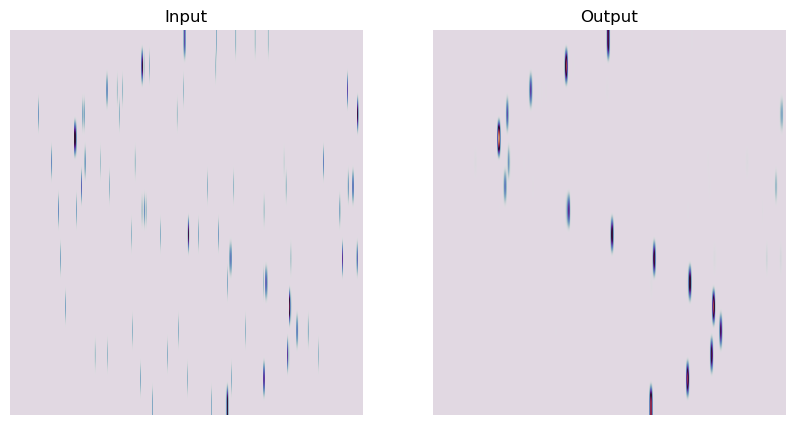

In [46]:
idx = 10
name = None#"/sdf/home/j/jhirschm/Publications/MRCO_XrayReconstruction_Paper_Results/figure2_1Pulse.pdf"
plot_ximg_dn(inputs[idx,:,:].squeeze(), outputs[idx,:,:].squeeze(), name, "twilight")




             